In [2]:
import mne
import nibabel as nib
from skimage import io
from matplotlib import pyplot as plt
from scipy import signal, stats

import numpy as np
import os

%matplotlib inline

In [3]:
!ls ./reports/low_net3D_1_all/40

logs  models


In [4]:
checkpoint_name = './reports/low_net3D_1_all'

In [16]:
def get_stats(man):
    base_results = np.load('{}/{}/base_losses.npy'.format(checkpoint_name, man))
    net_results = np.load('{}/{}/net_losses.npy'.format(checkpoint_name, man))
    frame_index_list = np.load('{}/{}/frame_index_list.npy'.format(checkpoint_name, man))
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, man))
    total_sum_of_squares = np.load('{}/{}/base_test_mean_losses.npy'.format(checkpoint_name, man))
    residual_loss_list = np.load('{}/{}/residual_loss_list.npy'.format(checkpoint_name, man))
    
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, man))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, man))
    
    
    base_loss = np.sum(base_results)
    net_loss = np.sum(net_results)
    r2 = 1 - net_loss/base_loss
    
    slice_losses = np.zeros([30, 64, 64])
    slice_base_losses = np.zeros([30, 64, 64])
    slice_total_squares = np.zeros([30, 64, 64])
    residual_loss_num = np.zeros([30, 64, 64])
    residual_loss_denum = np.zeros([30, 64, 64])
    for i, slice_indx in enumerate(slice_index_list):
        slice_losses[slice_indx] += net_results[i] 
        slice_base_losses[slice_indx] += base_results[i]
        slice_total_squares[slice_indx] += total_sum_of_squares[i]
        residual_loss_num[slice_indx] += (net_predictions[i] - gt_predictions[i])**2
        residual_loss_denum[slice_indx] += (gt_predictions[i])**2

    for i in range(30):
        slice_losses[i] /= np.sum(slice_index_list == i)
        slice_base_losses[i] /= np.sum(slice_index_list == i)
        slice_total_squares[i] /= np.sum(slice_index_list == i)
    residual_loss = np.sqrt(residual_loss_num/(residual_loss_denum + 1e-9))
    return r2, slice_losses, slice_base_losses, slice_total_squares, residual_loss

def get_voxel_predictions(man, slice, indx1, indx2, slice_index_list=None, net_predictions=None, gt_predictions=None):
    if slice_index_list is None:
        slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, man))
    if net_predictions is None:
        net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, man))
    if gt_predictions is None:
        gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, man))
    
    net_voxel_preds = []
    gt_voxel_preds = []
    for i in range(len(slice_index_list)):
        if slice_index_list[i] != slice:
            continue
        
        net_voxel_preds.append(net_predictions[i, indx1, indx2])
        gt_voxel_preds.append(gt_predictions[i, indx1, indx2])
        
    return net_voxel_preds, gt_voxel_preds

def get_correlations(man):
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, man))
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, man))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, man))
    
    result = np.zeros([30, 64, 64])
    for s in range(30):
        for i in range(64):
            for j in range(64):
                p, q = get_voxel_predictions(man, s, i, j, slice_index_list, net_predictions, gt_predictions)
                result[s, i, j], _ = stats.pearsonr(p, q)
    return result

def get_grad(man):
    return np.load('{}/{}/models/grad_statistic.npy'.format(checkpoint_name, man))[:, 0].mean(0)

In [6]:
def get_statistics_full(i):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[i])))
    net_predictions = np.load('{}/{}/net_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    gt_predictions = np.load('{}/{}/gt_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    slice_index_list = np.load('{}/{}/slice_index_list.npy'.format(checkpoint_name, str(all_people[i])))
    fmri_mean = fmri.mean(-1) / 4095 * 100
    num = np.zeros([30, 64, 64])
    denum = np.zeros([30, 64, 64])

    for i, indx in enumerate(slice_index_list):
        mean = fmri_mean[..., indx]
        num[indx] += (net_predictions[i] - gt_predictions[i]) ** 2
        denum[indx] += (gt_predictions[i] - mean) ** 2
    stats = np.sqrt(num / (denum + 1e-9))
    return stats

In [7]:
def get_statistics_train(i):
    fmri_path = '../../data/fMRI/'
    fmri = read_img(os.path.join(fmri_path, str(all_people[i])))
    net_predictions = np.load('{}/{}/models/net_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    gt_predictions = np.load('{}/{}/models/gt_predictions.npy'.format(checkpoint_name, str(all_people[i])))
    slice_index_list = np.load('{}/{}/models/slice_index_list.npy'.format(checkpoint_name, str(all_people[i])))
    fmri_mean = fmri[..., :210].mean(-1) / 4095 * 100
    num = np.zeros([30, 64, 64])
    denum = np.zeros([30, 64, 64])

    for i, indx in enumerate(slice_index_list):
        mean = fmri_mean[..., indx]
        num[indx] += (net_predictions[i] - gt_predictions[i]) ** 2
        denum[indx] += (gt_predictions[i] - mean) ** 2
    stats = np.sqrt(num / (denum + 1e-9))
    return stats

In [8]:
def read_img(path):
    files = os.listdir(path)
    for file in files:
        if file[-12:] == 'cross.nii.gz':
            return nib.load(os.path.join(path, file)).get_data()

In [9]:
fmri_path = '../../data/fMRI/'
all_people = ['40', '49', '37', '36', '50', '47', '32', '48', '46', '35', '42', '43', '39', '44', '38', '41', '45']

In [10]:
for i in range(2, 11):
    print(i/10, end=' & ')

0.2 & 0.3 & 0.4 & 0.5 & 0.6 & 0.7 & 0.8 & 0.9 & 1.0 & 

In [12]:
for i in range(len(all_people)):
    print(all_people[i],  end=' & ')
    s = get_statistics_train(i)
    for i in [4, 6, 8, 10]:
        print("{0:.6f}".format((s < i/10).mean()), end=' & ')
    print("{0:.6f}".format((s < 1).mean()), end=' \\\\ ')
    print()
    print('\hline')

40 & 0.041382 & 0.138159 & 0.263558 & 0.513273 & 0.513273 \\ 
\hline
49 & 0.057389 & 0.161759 & 0.277327 & 0.748470 & 0.748470 \\ 
\hline
37 & 

FileNotFoundError: [Errno 2] No such file or directory: './reports/low_net3D_1_all/37/models/net_predictions.npy'

In [12]:
for i in range(len(all_people)):
    print(all_people[i],  end=' & ')
    s = get_statistics_full(i)
    for i in [4, 6, 8, 10]:
        print("{0:.6f}".format((s < i/10).mean()), end=' & ')
    print("{0:.6f}".format((s < 1).mean()), end=' \\\\ ')
    print()
    print('\hline')

40 & 0.022266 & 0.066178 & 0.153271 & 0.364380 & 0.364380 \\ 
\hline
49 & 0.028898 & 0.082975 & 0.157796 & 0.485107 & 0.485107 \\ 
\hline
37 & 0.017643 & 0.047176 & 0.107161 & 0.277279 & 0.277279 \\ 
\hline
36 & 0.018278 & 0.046704 & 0.124154 & 0.355526 & 0.355526 \\ 
\hline
50 & 0.028304 & 0.081771 & 0.151709 & 0.371086 & 0.371086 \\ 
\hline
47 & 0.014762 & 0.037378 & 0.105729 & 0.334310 & 0.334310 \\ 
\hline
32 & 0.026042 & 0.054793 & 0.100317 & 0.284774 & 0.284774 \\ 
\hline
48 & 0.014054 & 0.025846 & 0.070345 & 0.302661 & 0.302661 \\ 
\hline
46 & 0.015479 & 0.047811 & 0.114803 & 0.299308 & 0.299308 \\ 
\hline
35 & 0.023486 & 0.070931 & 0.146924 & 0.347827 & 0.347827 \\ 
\hline
42 & 0.002181 & 0.014038 & 0.029704 & 0.098201 & 0.098201 \\ 
\hline
43 & 0.041064 & 0.107951 & 0.189966 & 0.386873 & 0.386873 \\ 
\hline
39 & 0.021582 & 0.067489 & 0.156421 & 0.329329 & 0.329329 \\ 
\hline
44 & 0.014144 & 0.043164 & 0.119507 & 0.330892 & 0.330892 \\ 
\hline
38 & 0.001978 & 0.004915 & 0.00907

In [15]:
collage = np.concatenate([fmri.mean(-1)[..., i]/4095 for i in range(30)], axis = 0)

stats = get_statistics_train(1)

stats[stats > 2] = 2

collage_stats = np.concatenate([(1 - (stats[i]/2)) for i in range(30)], axis = 0)
collage_stats_tresh2 = np.concatenate([(stats[i]<.2) for i in range(30)], axis = 0)
collage_stats_tresh4 = np.concatenate([(stats[i]<.4) for i in range(30)], axis = 0)
collage_stats_tresh6 = np.concatenate([(stats[i]<.6) for i in range(30)], axis = 0)
collage_stats_tresh8 = np.concatenate([(stats[i]<.8) for i in range(30)], axis = 0)
collage_stats_tresh1 = np.concatenate([(stats[i]<1) for i in range(30)], axis = 0)

collage = np.concatenate([collage, collage_stats, collage_stats_tresh2, collage_stats_tresh4,collage_stats_tresh6, collage_stats_tresh8, collage_stats_tresh1], axis = 1)
io.imsave('coll_49_train_mean.png', collage)

NameError: name 'fmri' is not defined

In [13]:
def _plot_r2(r2_list):
    fig, axis = plt.subplots(6, 5, figsize=[40, 40])
    for slice_indx in range(30):
        img = r2_list[:,slice_indx].mean(0)
        im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma', vmin=0, vmax=1)
        plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])

def plot_r2(men_list=all_people):
    sll = []
    sbll = []
    for man in men_list:
        sll.append(slice_losses_list[all_people_dict[man]])
        sbll.append(slice_total_squares_list[all_people_dict[man]])
    sll = np.array(sll)
    sbll = np.array(sbll)
    _plot_r2(1-sll/(sbll+1e-7))
    
def plot_correlations(men_list=all_people):
    res = []
    for man in men_list:
        res.append(get_correlations(man))
    res = sum(res)/len(res)
    fig, axis = plt.subplots(6, 5, figsize=[40, 40])
    for slice_indx in range(30):
        img = res[slice_indx]
        im = axis[slice_indx%6, slice_indx//6].imshow(img, cmap='plasma', vmin=-1, vmax=1)
        plt.colorbar(im, ax=axis[slice_indx%6, slice_indx//6])
        
def plot_voxel_predictions(man, slice, indx1, indx2):
    net, gt = get_voxel_predictions(man, slice, indx1, indx2)
    plt.plot(net, label='net')
    plt.plot(gt, label='ground truth')
    plt.legend()
    plt.show()
    
def plot_grad(men_list=all_people):
    grad_list = [get_grad(man) for man in men_list]
    grad_list = sum(grad_list) / len(grad_list)
    fig, axis = plt.subplots(16, 4, figsize=[40, 160])
    for slice_indx in range(64):
        img = grad_list[slice_indx]
        im = axis[slice_indx%16, slice_indx//16].imshow(img, cmap='plasma', vmin=0, vmax=np.max(grad_list))
        plt.colorbar(im, ax=axis[slice_indx%16, slice_indx//16])

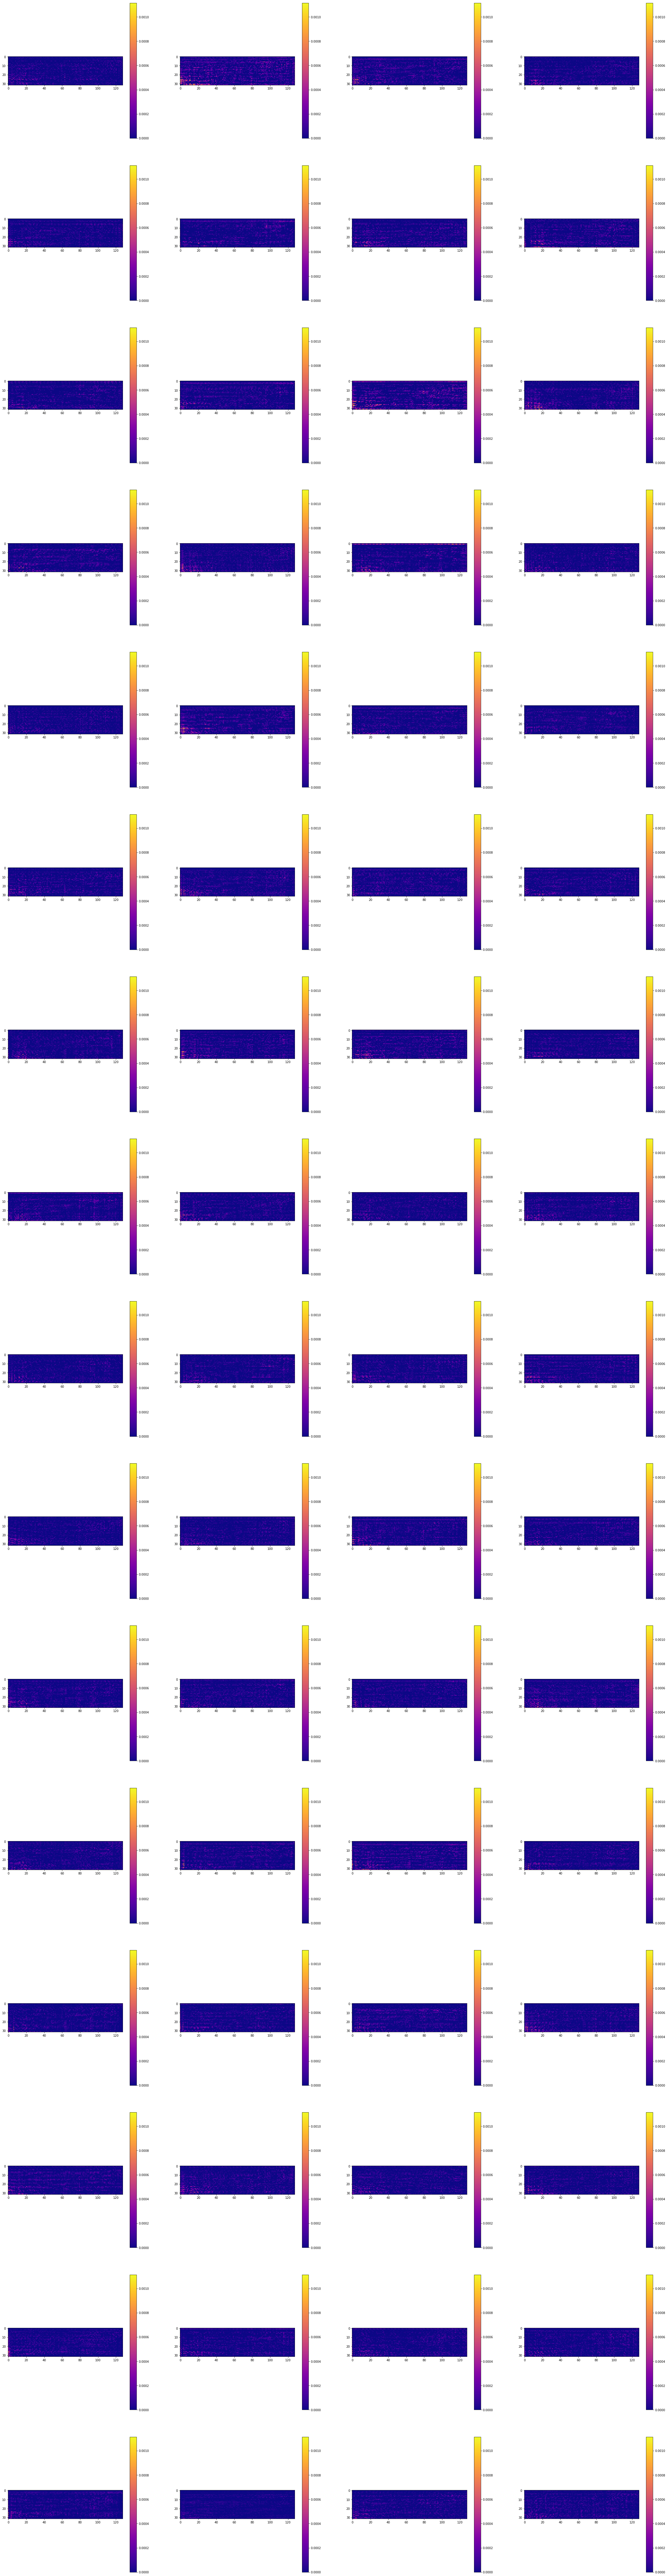

In [18]:
plot_grad([49])

In [87]:
stats = get_statistics_full(0)

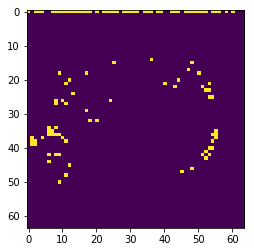

In [90]:
plt.imshow(stats[10] < .4)

In [94]:
print(stats[10, 26, 54])

0.692476631481


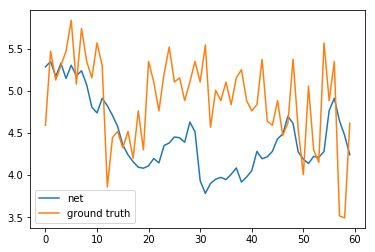

In [98]:
plot_voxel_predictions(40, 10, 25, 54)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


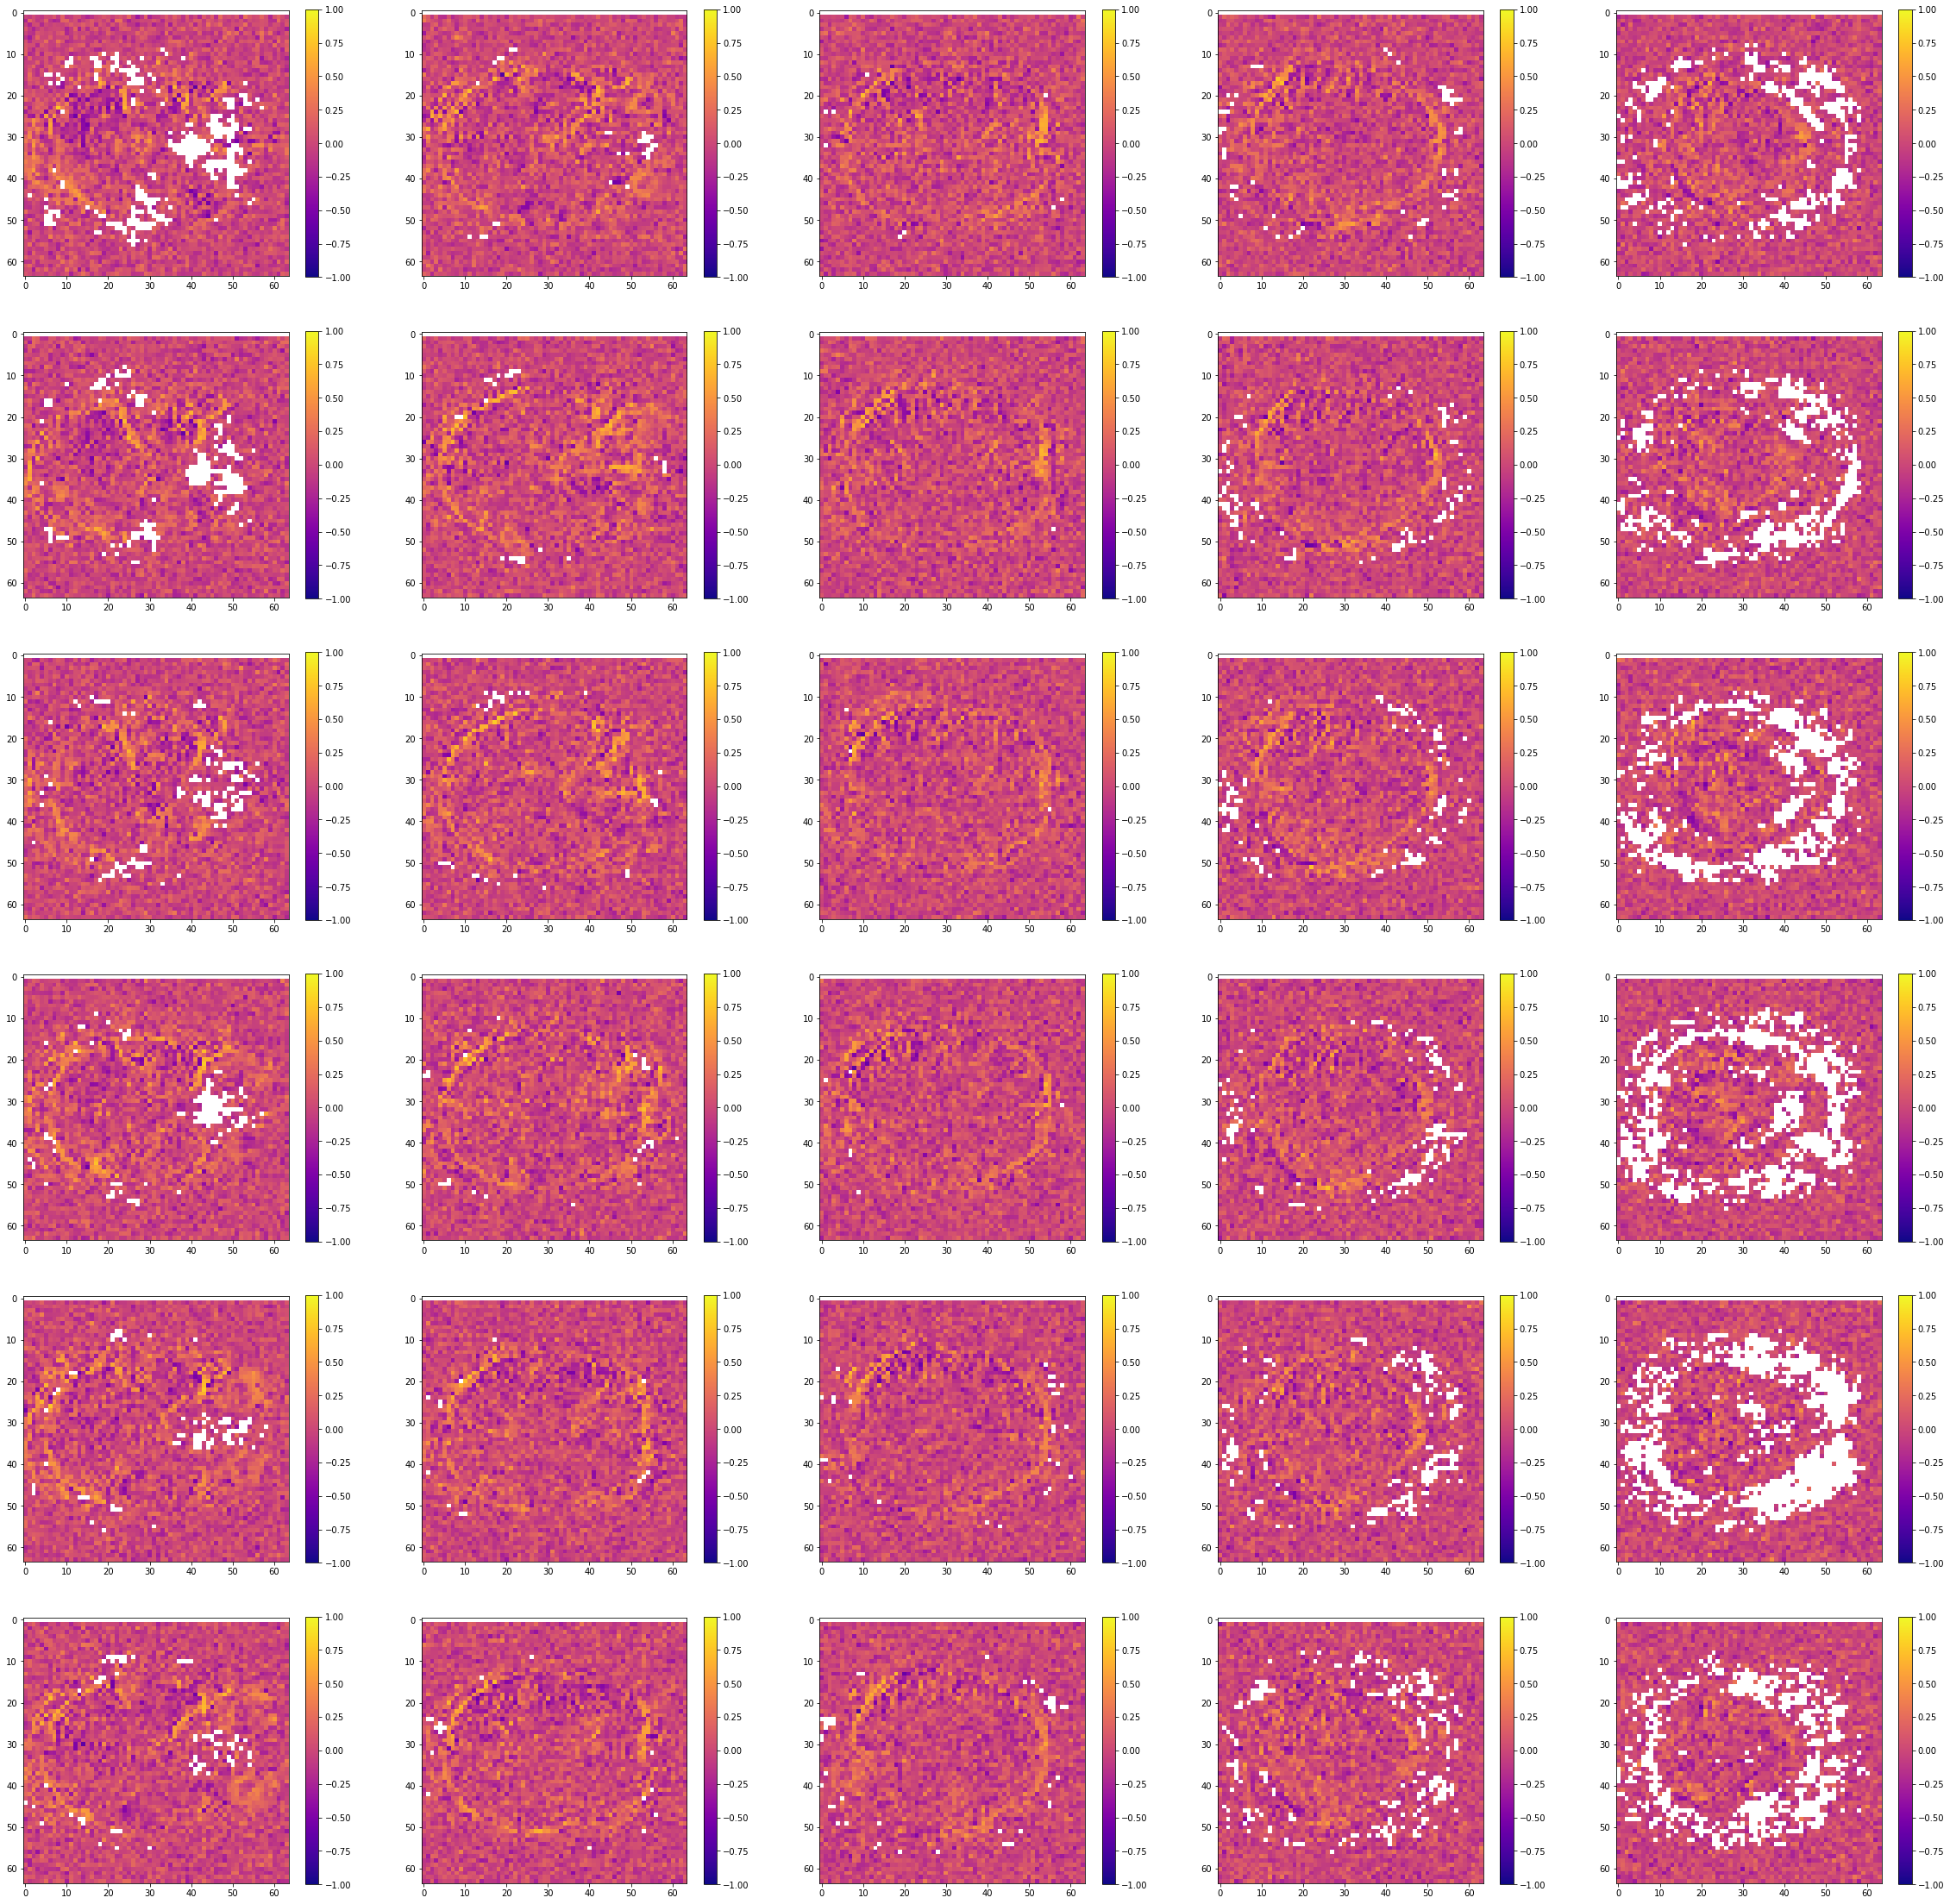

In [17]:
plot_correlations([40])

In [82]:
fmrt = read_img(os.path.join(fmri_path, str(all_people[i])))

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


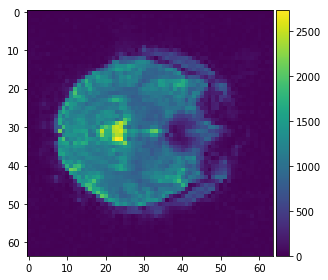

In [86]:
io.imshow(fmrt[..., 10, 0])

In [83]:
fmrt.shape

(64, 64, 30, 300)